# Libraries

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import PIL # pillow - image processing
import tensorflow as tf
from PIL import Image
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib
import matplotlib.pyplot as plt

In [33]:
import os
#os.chdir(r"D:\PhD Classes (Big_files)\Neural Networks\Neural Networks\Project\2nd_dataset_image\Cropped_1Channel_Mask")
#os.chdir(r'/home/said.mejia/Projects/Deep_Learning/Dataset')
print(os.path.dirname(os.getcwd()))

C:\Users\said_\Google Drive\THE CITY COLLEGE OF NEW YORK\Ph.D.Classes\Spring21\Neural Networks\Project\Repo_CCNY_3\final-project-landandbuildingsatimg-ccny\notebooks


In [4]:
import sys
sys.path
sys.path.append(r'../../src/models/')

In [5]:
from image_segmentation.keras_segmentation.models.unet import vgg_unet
from image_segmentation.keras_segmentation.models.unet import resnet50_unet
from image_segmentation.keras_segmentation.models.segnet import vgg_segnet
from image_segmentation.keras_segmentation.models.segnet import resnet50_segnet

Segmentation Models: using `keras` framework.


# PLEASE READ LINE BELLOW

### Before use this notebook, please create a folder in githubfolder/models/Save_Models or run the following commented line

In [6]:
os.mkdir(r'../../models/Save_Models')

# Reading Images and Masks

In [7]:
reading_images = glob.glob(r'../../data/processed/Balanced_80/test/Images/*.png')
reading_masks = glob.glob(r'../../data/processed/Balanced_80/test/Masks/*.png')
img_num = 9

In [8]:
img = PIL.Image.open(reading_images[img_num], 'r')
mask = PIL.Image.open(reading_masks[img_num], 'r')

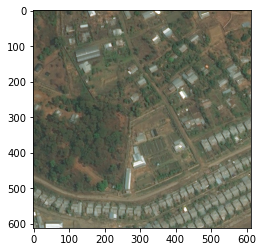

In [9]:
plt.imshow(np.asarray(img))

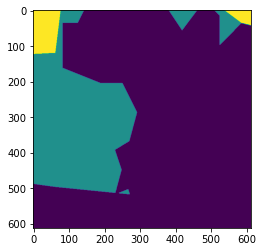

In [10]:
plt.imshow(np.asarray(mask))

# GPU

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

1 Physical GPUs, 1 Logical GPU


# Plot Function

In [12]:
import matplotlib
from matplotlib.colors import ListedColormap


def plot_label_plot(mask, labels, col_dict, ax, fig):
    # Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
    # col_dict={1:"blue",
    #           2:"red",
    #           3:"orange",
    #           4:"green",
    #           5:"yellow",
    #           6:"purple",
    #           7:"grey"}
    
    # We create a colormar from our list of colors
    cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
    
    # Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
    # labels = np.array(['urban_land','agriculture_land','rangeland','forest_land','water','barren_land','unknown'])
    len_lab = len(labels)
    
    
    # prepare normalizer
    ## Prepare bins for the normalizer
    norm_bins = np.sort([*col_dict.keys()]) + 0.5
    norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
    #print(norm_bins)
    ## Make normalizer and formatter
    norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
    fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])
    
    # Plot our figure
#     fig,ax = plt.subplots()
    im = ax.imshow(mask, cmap=cm, norm=norm)
    
    diff = norm_bins[1:] - norm_bins[:-1]
    tickz = norm_bins[:-1] + diff / 2
    cb = fig.colorbar(im, format=fmt, ticks=tickz)
    return ax, fig

In [13]:
def plot_label(mask, labels, col_dict, ax):
    # Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
    # col_dict={1:"blue",
    #           2:"red",
    #           3:"orange",
    #           4:"green",
    #           5:"yellow",
    #           6:"purple",
    #           7:"grey"}
    
    # We create a colormar from our list of colors
    cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
    
    # Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
    # labels = np.array(['urban_land','agriculture_land','rangeland','forest_land','water','barren_land','unknown'])
    len_lab = len(labels)
    
    
    # prepare normalizer
    ## Prepare bins for the normalizer
    norm_bins = np.sort([*col_dict.keys()]) + 0.5
    norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
    #print(norm_bins)
    ## Make normalizer and formatter
    norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
    fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])
    
    # Plot our figure
#     fig,ax = plt.subplots()
    im = ax.imshow(mask, cmap=cm, norm=norm)
    
    diff = norm_bins[1:] - norm_bins[:-1]
    tickz = norm_bins[:-1] + diff / 2
    #cb = fig.colorbar(im, format=fmt, ticks=tickz)

# History Function

In [14]:
def plot_history(history):
       
    acc = history.history['iou_score']
    val_acc = history.history['val_iou_score']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

## Ploting the class labels

In [15]:
labels = pd.read_csv('../../data/processed/Balanced_80/class_dict.csv')
classes = list(labels['name'])
classes

['unknown',
 'urban_land',
 'agriculture_land',
 'rangeland',
 'forest_land',
 'water',
 'barren_land']

In [16]:
labels = classes
col_dict = {0: 'blue', 1: 'red', 2: 'orange', 3: 'green', 
           4: 'yellow', 5: 'purple', 6: 'grey', }
col_dict

{0: 'blue',
 1: 'red',
 2: 'orange',
 3: 'green',
 4: 'yellow',
 5: 'purple',
 6: 'grey'}

# Paths

In [17]:
weight_path= ['Model_Best_Weights_vgg_unet.hdf5',
             'Model_Best_Weights_resnet50_unet.hdf5',
             'Model_Best_Weights_vgg_segnet.hdf5',
             'Model_Best_Weights_resnet50_segnet.hdf5']
save_path= ['Model_Save_Model_vgg_unet.h5',
             'Model_Save_Model_resnet50_unet.h5',
             'Model_Save_Model_vgg_segnet.h5',
             'Model_Save_Model_resnet50_segnet.h5']
image_path= ['Model_vgg_unet.png',
             'Model_resnet50_unet.png',
             'Model_vgg_segnet.png',
             'Model_resnet50_segnet.png']

# 0. VGG_UNET

In [21]:
i = 0

In [23]:
model_0 = vgg_unet(n_classes=7 , input_height=512, input_width=512)
#model_0.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 512, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 256, 64) 0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [72]:
callbacks = [
    ModelCheckpoint(
                filepath= '../../models/Save_Models/' + weight_path[i],
                        save_best_only=True,
                        verbose=1), 
    EarlyStopping(patience=10,
                           restore_best_weights=True,
                           mode='max')
]

In [73]:
from datetime import datetime
start = datetime.now()
model_0_hist = model_0.train(
    input_height = 612,
    input_width = 612,
    verify_dataset = False,
    train_images =  "../../data/processed/Balanced_80/train/Images/",
    train_annotations = "../../data/processed/Balanced_80/train/Masks/",
    validate= True,
    val_images =  "../../data/processed/Balanced_80/val/Images/",
    val_annotations = "../../data/processed/Balanced_80/val/Masks/",
    epochs=100, 
    callbacks = callbacks
)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))

Epoch 1/1
512/512 [==============================] - 240s 469ms/step - loss: 0.7245 - iou_score: 0.2462 - f1-score: 0.3766 - val_loss: 0.2501 - val_iou_score: 0.3887 - val_f1-score: 0.5345

Epoch 00001: val_loss improved from inf to 0.25008, saving model to ../../models/Save_Models/Model_Best_Weights_vgg_unet.hdf5

Time Taken for testing: 0:04:03.108923


C:\Users\said_\Anaconda3\envs\Tensorflow_Deep_Learning\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


## Saving the model

In [76]:
model_0.save('../../models/Save_Models/' + save_path[i])

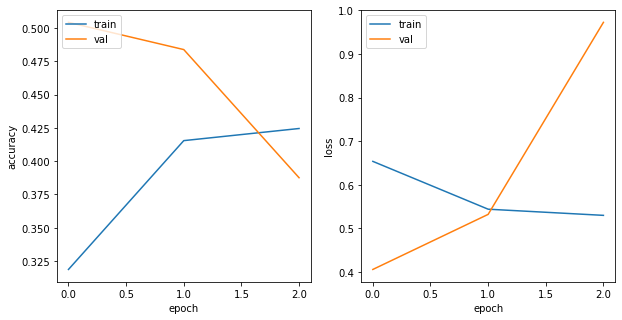

In [27]:
plot_history(model_0_hist)

In [56]:
out = model_0.predict_segmentation(
    inp= reading_images[img_num],
    out_fname= '../../models/Save_Models/' + image_path[i]
)

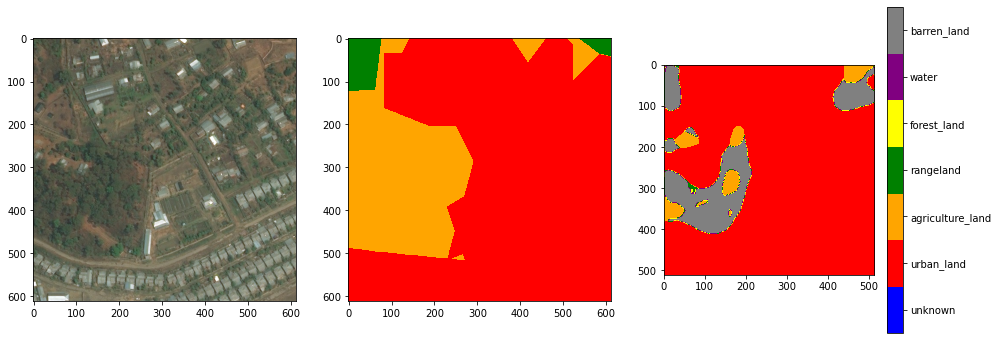

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
# fig.subplots_adjust(hspace=0.1)
axes[0].imshow(np.asarray(img))
axes[1] = plot_label(np.asarray(mask), labels,col_dict, axes[1])
axes[2] = plot_label_plot(np.asarray(out), labels,col_dict, axes[2], fig)

# 1. RESNET_UNET

In [25]:
i = 1

In [27]:
model_1 = resnet50_unet(n_classes=7 , input_height=512, input_width=512)
#model_1.summary()

In [69]:
callbacks = [
    ModelCheckpoint(
                filepath= '../../models/Save_Models/' + weight_path[i],
                        save_best_only=True,
                        verbose=1), 
    EarlyStopping(patience=10,
                           restore_best_weights=True,
                           mode='max')
]

In [17]:
from datetime import datetime
start = datetime.now()
model_1_hist = model_1.train(
    input_height = 612,
    input_width = 612,
    verify_dataset = False,
    train_images =  "../../data/processed/Balanced_80/train/Images/",
    train_annotations = "../../data/processed/Balanced_80/train/Masks/",
    validate= True,
    val_images =  "../../data/processed/Balanced_80/val/Images/",
    val_annotations = "../../data/processed/Balanced_80/val/Masks/",
    epochs=100, 
    callbacks = callbacks
)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))

Epoch 1/3
512/512 [==============================] - 219s 429ms/step - loss: 0.6538 - iou_score: 0.3187 - f1-score: 0.4616 - val_loss: 0.4060 - val_iou_score: 0.5042 - val_f1-score: 0.6436

Epoch 00001: val_loss improved from inf to 0.40605, saving model to Model_Best_Weights_vgg_unet.hdf5


C:\Users\said_\Anaconda3\envs\Tensorflow_Deep_Learning\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 2/3
512/512 [==============================] - 214s 417ms/step - loss: 0.5442 - iou_score: 0.4154 - f1-score: 0.5666 - val_loss: 0.5323 - val_iou_score: 0.4838 - val_f1-score: 0.6190

Epoch 00002: val_loss did not improve from 0.40605
Epoch 3/3
512/512 [==============================] - 213s 417ms/step - loss: 0.5301 - iou_score: 0.4245 - f1-score: 0.5748 - val_loss: 0.9726 - val_iou_score: 0.3876 - val_f1-score: 0.5190

Epoch 00003: val_loss did not improve from 0.40605

Time Taken for testing: 0:10:49.202248


## Saving the model

In [19]:
model_1.save('../../models/Save_Models/' + save_path[i])

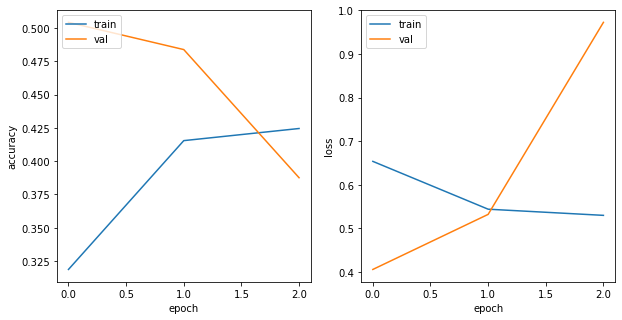

In [27]:
plot_history(model_1_hist)

In [56]:
out = model_1.predict_segmentation(
    inp= reading_images[img_num],
    out_fname= '../../models/Save_Models/' + image_path[i]
)

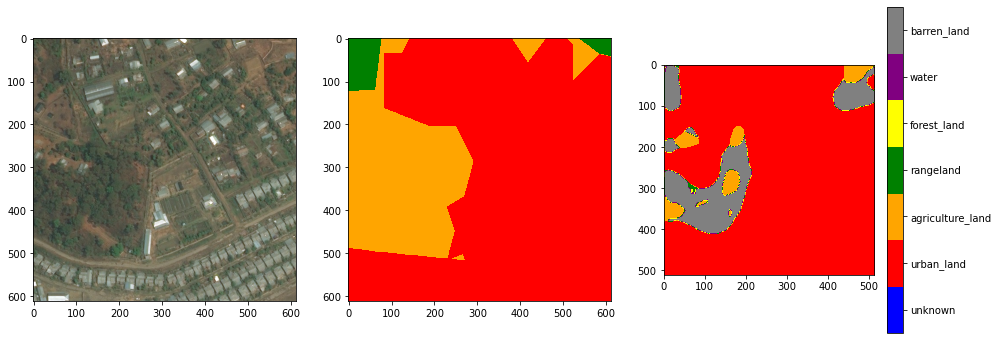

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
# fig.subplots_adjust(hspace=0.1)
axes[0].imshow(np.asarray(img))
axes[1] = plot_label(np.asarray(mask), labels,col_dict, axes[1])
axes[2] = plot_label_plot(np.asarray(out), labels,col_dict, axes[2], fig)

# 2. VGG_SEGNET

In [67]:
i = 2

In [29]:
model_2 = vgg_segnet(n_classes=7 , input_height=512, input_width=512)
#model_2.summary()

In [75]:
callbacks = [
    ModelCheckpoint(
                filepath= '../../models/Save_Models/' + weight_path[i],
                        save_best_only=True,
                        verbose=1), 
    EarlyStopping(patience=10,
                           restore_best_weights=True,
                           mode='max')
]

In [17]:
from datetime import datetime
start = datetime.now()
model_2_hist = model_2.train(
    input_height = 612,
    input_width = 612,
    verify_dataset = False,
    train_images =  "../../data/processed/Balanced_80/train/Images/",
    train_annotations = "../../data/processed/Balanced_80/train/Masks/",
    validate= True,
    val_images =  "../../data/processed/Balanced_80/val/Images/",
    val_annotations = "../../data/processed/Balanced_80/val/Masks/",
    epochs=100, 
    callbacks = callbacks
)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))

Epoch 1/3
512/512 [==============================] - 219s 429ms/step - loss: 0.6538 - iou_score: 0.3187 - f1-score: 0.4616 - val_loss: 0.4060 - val_iou_score: 0.5042 - val_f1-score: 0.6436

Epoch 00001: val_loss improved from inf to 0.40605, saving model to Model_Best_Weights_vgg_unet.hdf5


C:\Users\said_\Anaconda3\envs\Tensorflow_Deep_Learning\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 2/3
512/512 [==============================] - 214s 417ms/step - loss: 0.5442 - iou_score: 0.4154 - f1-score: 0.5666 - val_loss: 0.5323 - val_iou_score: 0.4838 - val_f1-score: 0.6190

Epoch 00002: val_loss did not improve from 0.40605
Epoch 3/3
512/512 [==============================] - 213s 417ms/step - loss: 0.5301 - iou_score: 0.4245 - f1-score: 0.5748 - val_loss: 0.9726 - val_iou_score: 0.3876 - val_f1-score: 0.5190

Epoch 00003: val_loss did not improve from 0.40605

Time Taken for testing: 0:10:49.202248


## Saving the model

In [19]:
model_2.save('../../models/Save_Models/' + save_path[i])

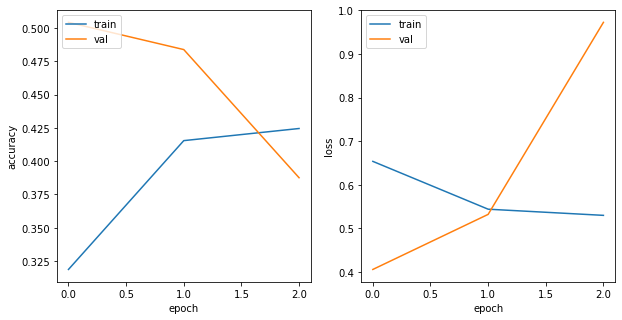

In [27]:
plot_history(model_2_hist)

In [56]:
out = model_2.predict_segmentation(
    inp= reading_images[img_num],
    out_fname= '../../models/Save_Models/' + image_path[i]
)

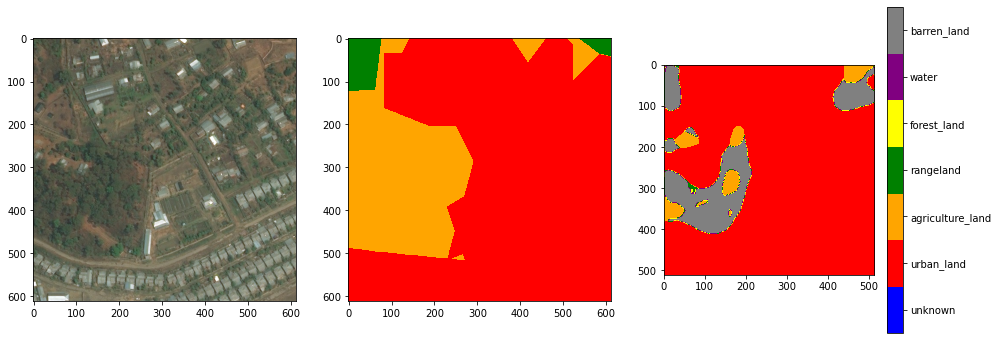

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
# fig.subplots_adjust(hspace=0.1)
axes[0].imshow(np.asarray(img))
axes[1] = plot_label(np.asarray(mask), labels,col_dict, axes[1])
axes[2] = plot_label_plot(np.asarray(out), labels,col_dict, axes[2], fig)

# 3. RESNET_SEGNET

In [78]:
i = 3

In [31]:
model_3 = resnet50_segnet(n_classes=7 , input_height=512, input_width=512)
#model_3.summary()

In [75]:
callbacks = [
    ModelCheckpoint(
                filepath= '../../models/Save_Models/' + weight_path[i],
                        save_best_only=True,
                        verbose=1), 
    EarlyStopping(patience=10,
                           restore_best_weights=True,
                           mode='max')
]

In [17]:
from datetime import datetime
start = datetime.now()
model_3_hist = model_3.train(
    input_height = 612,
    input_width = 612,
    verify_dataset = False,
    train_images =  "../../data/processed/Balanced_80/train/Images/",
    train_annotations = "../../data/processed/Balanced_80/train/Masks/",
    validate= True,
    val_images =  "../../data/processed/Balanced_80/val/Images/",
    val_annotations = "../../data/processed/Balanced_80/val/Masks/",
    epochs=100, 
    callbacks = callbacks
)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))

Epoch 1/3
512/512 [==============================] - 219s 429ms/step - loss: 0.6538 - iou_score: 0.3187 - f1-score: 0.4616 - val_loss: 0.4060 - val_iou_score: 0.5042 - val_f1-score: 0.6436

Epoch 00001: val_loss improved from inf to 0.40605, saving model to Model_Best_Weights_vgg_unet.hdf5


C:\Users\said_\Anaconda3\envs\Tensorflow_Deep_Learning\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 2/3
512/512 [==============================] - 214s 417ms/step - loss: 0.5442 - iou_score: 0.4154 - f1-score: 0.5666 - val_loss: 0.5323 - val_iou_score: 0.4838 - val_f1-score: 0.6190

Epoch 00002: val_loss did not improve from 0.40605
Epoch 3/3
512/512 [==============================] - 213s 417ms/step - loss: 0.5301 - iou_score: 0.4245 - f1-score: 0.5748 - val_loss: 0.9726 - val_iou_score: 0.3876 - val_f1-score: 0.5190

Epoch 00003: val_loss did not improve from 0.40605

Time Taken for testing: 0:10:49.202248


## Saving the model

In [19]:
model_3.save('../../models/Save_Models/' + save_path[i])

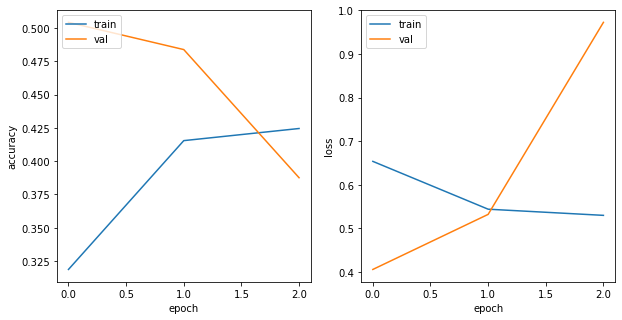

In [27]:
plot_history(model_3_hist)

In [56]:
out = model_3.predict_segmentation(
    inp= reading_images[img_num],
    out_fname= '../../models/Save_Models/' + image_path[i]
)

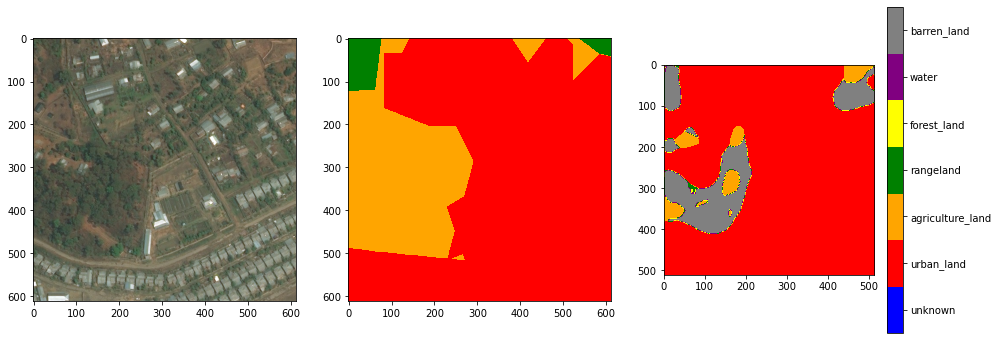

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
# fig.subplots_adjust(hspace=0.1)
axes[0].imshow(np.asarray(img))
axes[1] = plot_label(np.asarray(mask), labels,col_dict, axes[1])
axes[2] = plot_label_plot(np.asarray(out), labels,col_dict, axes[2], fig)